In [1]:
#Import Libraries
import pandas as pd
import os
from google.cloud import bigquery
from datetime import date
from google.api_core.exceptions import Conflict
from statsmodels.tools.eval_measures import rmse, mse

In [2]:
#Inititate the client
project_id = "bridge-data-analytics-app" #update the project
client = bigquery.Client(project=project_id)
user = os.getenv("USER")

#create the dataset reference
dataset_id = f"{client.project}.nakul" #update the dataset
dataset = bigquery.Dataset(dataset_ref=dataset_id)
dataset.location = "australia-southeast1"

# Send the dataset to the API for creation, with an explicit timeout.
# Raises google.api_core.exceptions.Conflict if the Dataset already
# exists within the project.
try:
    dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
    print("Created dataset {}.{}".format(client.project, dataset.dataset_id))
except Conflict as c:
    print(f"Cannot create due to {c}") 
    

Cannot create due to 409 POST https://bigquery.googleapis.com/bigquery/v2/projects/bridge-data-analytics-app/datasets?prettyPrint=false: Already Exists: Dataset bridge-data-analytics-app:nakul


In [3]:
#Read data
data = pd.read_csv(f"/Users/{user}/forecasting-part-two/victoria_covid_cases_source_updated.csv", parse_dates=True)

In [4]:
#Load data bq
data.to_gbq(destination_table=f"{dataset.dataset_id}.victoria_cases_by_postcode_lga", 
                                project_id=client.project,
                                if_exists="replace")

1it [00:04,  4.40s/it]


In [5]:
#Get the data and aggregate it in bigquery

date_column = "diagnosis_date"
label = "total"

table_id = f"{client.project}.{dataset.dataset_id}.vic_daily_cases"

job_config = bigquery.QueryJobConfig(destination=table_id)
job_config.write_disposition = "WRITE_TRUNCATE" #overwrite the table

sql = f"""select 
          parse_date('%Y-%m-%d',{date_column}) as {date_column}, 
          count(Postcode) as {label} 
          from {dataset.dataset_id}.victoria_cases_by_postcode_lga
          group by {date_column}
          order by {date_column}
       """

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

print("Query results loaded to the table {}".format(table_id))


Query results loaded to the table bridge-data-analytics-app.nakul.vic_daily_cases


In [6]:
#Configuration of train test split and table and model names
train_test_split="2021-08-20"
training_table=f"{client.project}.{dataset.dataset_id}.vic_daily_cases_training"
testing_table=f"{client.project}.{dataset.dataset_id}.vic_daily_cases_testing"
model_name=f"{dataset.dataset_id}.vic_cases_bq_arima_model"

In [7]:
#Creating training and testing tables

##TRAINING
job_config = bigquery.QueryJobConfig(destination=training_table)
job_config.write_disposition = "WRITE_TRUNCATE" #overwrite the table

sql = f"select * FROM {table_id} where {date_column} <= '{train_test_split}'"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

print("Query results loaded to the table {}".format(training_table))


##TESTING
job_config = bigquery.QueryJobConfig(destination=testing_table)
job_config.write_disposition = "WRITE_TRUNCATE" #overwrite the table

sql = f"select * FROM {table_id} where {date_column} > '{train_test_split}'"

# Start the query, passing in the extra configuration.
query_job = client.query(sql, job_config=job_config)  # Make an API request.
query_job.result()  # Wait for the job to complete.

print("Query results loaded to the table {}".format(testing_table))

Query results loaded to the table bridge-data-analytics-app.nakul.vic_daily_cases_training
Query results loaded to the table bridge-data-analytics-app.nakul.vic_daily_cases_testing


In [8]:
#Defining model parameters
model_type = "ARIMA_PLUS"
auto_arima = "TRUE"
data_frequency = "AUTO_FREQUENCY"
decompose_series = "TRUE"

In [9]:
#CREATE THE MODEL AND TRAIN IT
#standardSQL
sql = f"""CREATE OR REPLACE MODEL {model_name}
OPTIONS
  (model_type = '{model_type}',
   time_series_timestamp_col = '{date_column}',
   time_series_data_col = '{label}',
   auto_arima = {auto_arima},
   data_frequency = '{data_frequency}',
   decompose_time_series = {decompose_series}
  ) AS
SELECT
  {date_column},
  {label}
FROM
  `{training_table}`
"""

query_job = client.query(sql)
query_job.result()#waiting for the result

In [10]:
#Evaluate the model parameters
query=f"""SELECT
            *
            FROM
            ML.ARIMA_EVALUATE(MODEL {model_name})
        """
model_evaluate = pd.read_gbq(query=query, project_id=client.project, dialect='standard')
model_evaluate

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,1,1,3,False,-1497.275861,3004.551721,10.888112,[WEEKLY],False,True,True,
1,3,1,1,False,-1497.557952,3005.115904,10.899231,[WEEKLY],False,True,True,
2,1,1,3,True,-1496.993068,3005.986136,10.877338,[WEEKLY],False,True,True,
3,3,1,1,True,-1497.230074,3006.460147,10.886756,[WEEKLY],False,True,True,
4,3,1,2,False,-1497.548983,3007.097967,10.898999,[WEEKLY],False,True,True,
5,3,1,2,True,-1497.214602,3008.429203,10.886197,[WEEKLY],False,True,True,
6,1,1,1,False,-1501.842377,3009.684755,11.065124,[WEEKLY],False,True,True,
7,1,1,2,False,-1501.485340,3010.970679,11.050985,[WEEKLY],False,True,True,
8,1,1,1,True,-1501.556746,3011.113492,11.054096,[WEEKLY],False,True,True,
9,2,1,1,False,-1501.576967,3011.153934,11.054626,[WEEKLY],False,True,True,


In [11]:
#Get model coefficients
query=f"""SELECT
            *
            FROM
            ML.ARIMA_COEFFICIENTS(MODEL {model_name})
        """
model_coefficients = pd.read_gbq(query=query, project_id=client.project, dialect='standard')
model_coefficients

,ar_coefficients,ma_coefficients,intercept_or_drift
0,[-0.9276134656660782],"[0.8889873470126303, -0.065943889298445, -0.12...",0.0


In [12]:
#FORECAST 5 days ahead

forecast_days=5
query=f"""
SELECT parse_date('%Y-%m-%d', format_datetime('%Y-%m-%d', forecast_timestamp)) as diagnosis_date, *
FROM
(
SELECT
 *
FROM
 ML.FORECAST(MODEL {model_name},
             STRUCT({forecast_days} AS horizon, 0.9 AS confidence_level))
)
"""
forecast_data=pd.read_gbq(query=query, project_id=client.project, dialect='standard')
forecast_data

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2025: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


,diagnosis_date,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2021-08-21,2021-08-21 00:00:00+00:00,56.920026,3.299714,0.9,51.498361,62.341691,51.498361,62.341691
1,2021-08-22,2021-08-22 00:00:00+00:00,55.668328,4.577263,0.9,48.147559,63.189098,48.147559,63.189098
2,2021-08-23,2021-08-23 00:00:00+00:00,55.397976,5.513076,0.9,46.339600,64.456352,46.339600,64.456352
3,2021-08-24,2021-08-24 00:00:00+00:00,55.653781,6.156042,0.9,45.538966,65.768595,45.538966,65.768595
4,2021-08-25,2021-08-25 00:00:00+00:00,61.768753,6.869615,0.9,50.481486,73.056021,50.481486,73.056021


In [13]:
#test data
query=f"""SELECT * FROM {testing_table} order by {date_column}"""
test_data=pd.read_gbq(query=query, project_id=client.project, dialect='standard')
test_data

,diagnosis_date,total
0,2021-08-21,66
1,2021-08-22,65
2,2021-08-23,48
3,2021-08-24,45
4,2021-08-25,80


In [14]:
RMSE = rmse(test_data.total, forecast_data.forecast_value)
print(f"rmse is {RMSE}")

rmse is 11.577024320666192


In [15]:
#train data
query=f"""SELECT * FROM {training_table} order by {date_column}"""
train_data=pd.read_gbq(query=query, project_id=client.project, dialect='standard')
train_data

,diagnosis_date,total
0,2020-01-25,1
1,2020-01-28,1
2,2020-01-30,1
3,2020-01-31,1
4,2020-02-22,2
...,...,...
409,2021-08-16,24
410,2021-08-17,24
411,2021-08-18,57
412,2021-08-19,56


In [16]:
#plot the data
train_data.set_index(f"{date_column}", inplace=True)
test_data.set_index(f"{date_column}", inplace=True)
forecast_data.set_index(f"{date_column}", inplace=True)

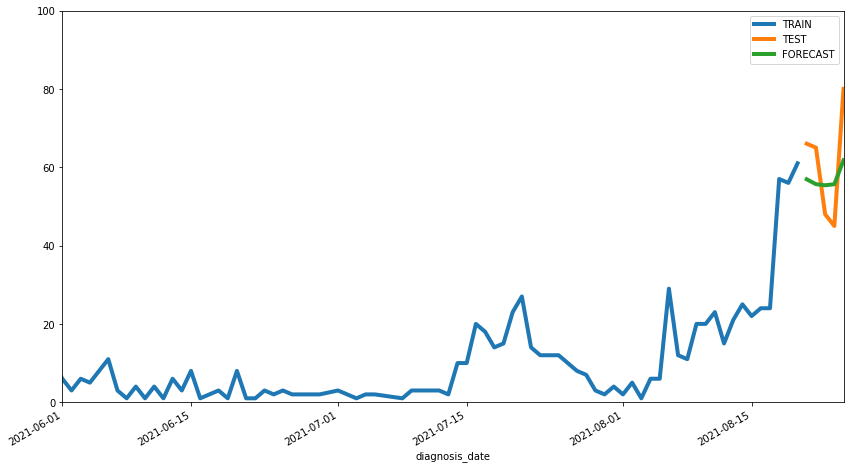

In [17]:
#Plot the training, test and Forecast
ax = train_data[f"{label}"].plot(figsize=(14,8), lw=4)
ax.plot(test_data[f"{label}"], lw=4)
ax.plot(forecast_data.forecast_value, lw=4)
ax.set_xlim(date(2021,6,1), date(2021,8,25))
ax.set_ylim(0,100)
ax.legend(["TRAIN","TEST","FORECAST"]);

In [18]:
#FORECAST INTO THE FUTURE


#CREATE THE MODEL AND TRAIN IT
#standardSQL
sql = f"""CREATE OR REPLACE MODEL {model_name}
OPTIONS
  (model_type = '{model_type}',
   time_series_timestamp_col = '{date_column}',
   time_series_data_col = '{label}',
   auto_arima = {auto_arima},
   data_frequency = '{data_frequency}',
   decompose_time_series = {decompose_series}
  ) AS
SELECT
  {date_column},
  {label}
FROM
  `{table_id}`
"""

query_job = client.query(sql)
query_job.result()#waiting for the result

In [19]:
#Forecasting 10 days ahead
forecast_days=10
query=f"""
SELECT parse_date('%Y-%m-%d', format_datetime('%Y-%m-%d', forecast_timestamp)) as diagnosis_date, *
FROM
(
SELECT
 *
FROM
 ML.FORECAST(MODEL {model_name},
             STRUCT({forecast_days} AS horizon, 0.9 AS confidence_level))
)
"""
forecast_data=pd.read_gbq(query=query, project_id=client.project, dialect='standard')
forecast_data

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/google/cloud/bigquery/table.py:2025: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


,diagnosis_date,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2021-08-26,2021-08-26 00:00:00+00:00,74.032615,3.403454,0.9,68.440497,79.624732,68.440497,79.624732
1,2021-08-27,2021-08-27 00:00:00+00:00,74.363967,4.686045,0.9,66.664462,82.063472,66.664462,82.063472
2,2021-08-28,2021-08-28 00:00:00+00:00,76.689365,5.783965,0.9,67.185898,86.192832,67.185898,86.192832
3,2021-08-29,2021-08-29 00:00:00+00:00,72.146459,6.626284,0.9,61.259002,83.033916,61.259002,83.033916
4,2021-08-30,2021-08-30 00:00:00+00:00,70.314600,7.438214,0.9,58.093086,82.536115,58.093086,82.536115
5,2021-08-31,2021-08-31 00:00:00+00:00,69.693125,8.114667,0.9,56.360150,83.026100,56.360150,83.026100
6,2021-09-01,2021-09-01 00:00:00+00:00,80.671855,8.786465,0.9,66.235068,95.108642,66.235068,95.108642
7,2021-09-02,2021-09-02 00:00:00+00:00,72.905591,9.369156,0.9,57.511402,88.299781,57.511402,88.299781
8,2021-09-03,2021-09-03 00:00:00+00:00,75.417021,9.953848,0.9,59.062139,91.771902,59.062139,91.771902
9,2021-09-04,2021-09-04 00:00:00+00:00,75.748630,10.474190,0.9,58.538791,92.958469,58.538791,92.958469


In [20]:
#Getting the full data 
full_data = train_data.append(test_data, sort=True)
forecast_data.set_index(f"{date_column}", inplace=True)

In [21]:
full_data

,total
diagnosis_date,
2020-01-25,1
2020-01-28,1
2020-01-30,1
2020-01-31,1
2020-02-22,2
...,...
2021-08-21,66
2021-08-22,65
2021-08-23,48


In [22]:
forecast_data.forecast_value

diagnosis_date
2021-08-26    74.032615
2021-08-27    74.363967
2021-08-28    76.689365
2021-08-29    72.146459
2021-08-30    70.314600
2021-08-31    69.693125
2021-09-01    80.671855
2021-09-02    72.905591
2021-09-03    75.417021
2021-09-04    75.748630
Name: forecast_value, dtype: float64

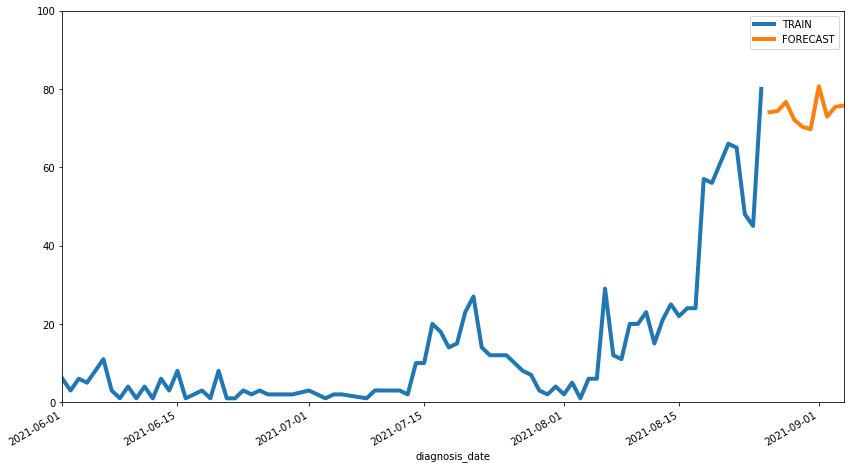

In [23]:
ax = full_data[f"{label}"].plot(figsize=(14,8), lw=4)
ax.plot(forecast_data.forecast_value, lw=4)
ax.set_xlim(date(2021,6,1), date(2021,9,4))
ax.set_ylim(0,100)
ax.legend(["TRAIN","FORECAST"]);